#Описание задачи

###Цель: Определения рейтинга приложения из датасета Google Play Store.

###Тип задачи: Классификация.

###Признаки: Могут включать рейтинг, количество отзывов, категорию, размер, цену и пр., где большинство данных категориальные и числовые.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Пусть у нас есть датасет с именем приложения и некоторыми его характеристиками:

* **App** - наименование приложения

* **Category** - категория приложения

* **Rating** - рейтинг приложения

* **Reviews** - число отзывов

* **Size** - размер приложения

* **Installs** - число установок приложения

* **Type** - платное или бесплатное

* **Price** - цена

* **Content Rating** - возрастное ограничение

* **Genres** - жанр приложения, дублирует категорию

* **Last Updated** - последнее обновление

* **Current Ver** - текущая версия

* **Android Ver** - совместимая версия системы


Попробуем по этим данным определить рейтинг приложения.

In [ ]:
url = 'googleplaystore.csv'
data = pd.read_csv(url, sep = ',', engine='python')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Удалим столбцы, которые нам не нужны или дублируют информацию.

In [ ]:
data = data.drop('Genres', axis = 1)\
            .drop('Last Updated', axis = 1)\
           .drop('Current Ver',    axis = 1)\
           .drop('Android Ver', axis = 1) \
            .drop('App', axis = 1) \
            .drop('Type', axis = 1)
data.head()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",0,Everyone
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",0,Everyone
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",0,Everyone
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",0,Teen
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",0,Everyone


## Начнём подготовку данных.
Для начала приведём произвольные типы столбцов к удобным.
Избавимся от лишних символов в данных.

In [ ]:
data['Reviews'] = pd.to_numeric(data['Reviews'], errors='coerce')
data['Size'] = data['Size'].str.extract('(\d+)')
data['Size'] = pd.to_numeric(data['Size'], errors='coerce')
data['Installs'] = data['Installs'].str.replace('[,+]', '')
data['Installs'] = pd.to_numeric(data['Installs'], errors='coerce')
data['Price'] = data['Price'].str.replace('[$]', '')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data.head()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating
0,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,0.0,Everyone
1,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,0.0,Everyone
2,ART_AND_DESIGN,4.7,87510.0,8.0,5000000.0,0.0,Everyone
3,ART_AND_DESIGN,4.5,215644.0,25.0,50000000.0,0.0,Teen
4,ART_AND_DESIGN,4.3,967.0,2.0,100000.0,0.0,Everyone


Выделим категориальные и числовые столбцы.

In [ ]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Category', 'Content Rating']
['Rating', 'Reviews', 'Size', 'Installs', 'Price']


In [ ]:
for c in categorical_columns:
    print(c, data[c].unique())

Category ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9']
Content Rating ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated'
 nan]


Заполним пропущенные значения.

In [ ]:
data.median(axis = 0)

Rating           4.3
Reviews       2094.0
Size            15.0
Installs    100000.0
Price            0.0
dtype: float64

In [ ]:
data = data.fillna(data.median(axis = 0), axis = 0)
data[numerical_columns].count(axis = 0)

Rating      10841
Reviews     10841
Size        10841
Installs    10841
Price       10841
dtype: int64

In [ ]:
data[categorical_columns].count(axis = 0)

Category          10841
Content Rating    10840
dtype: int64

In [ ]:
data['Content Rating'].describe()

count        10840
unique           6
top       Everyone
freq          8714
Name: Content Rating, dtype: object

In [ ]:
data['Content Rating'] = data['Content Rating'].fillna(data['Content Rating'].describe().top)
data[categorical_columns].count(axis = 0)

Category          10841
Content Rating    10841
dtype: int64

In [ ]:
data.describe(include = [object])

,Category,Content Rating
count,10841,10841
unique,34,6
top,FAMILY,Everyone
freq,1972,8715


In [ ]:
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])
data.describe(include = [object])

,Category,Content Rating
count,10841,10841
unique,34,6
top,FAMILY,Everyone
freq,1972,8715


Снова преобразуем тип некоторых столбцов.

In [ ]:
data['Reviews'] = data['Reviews'].astype(int)
data['Size'] = data['Size'].astype(int)
data['Installs'] = data['Installs'].astype(int)
data['Rating'] = data['Rating'].astype(int)
data.dtypes

Category           object
Rating              int64
Reviews             int64
Size                int64
Installs            int64
Price             float64
Content Rating     object
dtype: object

## Построим несколько зависимостей

In [ ]:
data.describe()

,Rating,Reviews,Size,Installs,Price
count,10841.000000,1.084100e+04,10841.000000,1.084100e+04,10841.000000
mean,3.810719,4.441121e+05,33.437045,1.546292e+07,1.027273
std,0.547520,2.927629e+06,91.210047,8.502557e+07,15.948971
min,1.000000,0.000000e+00,1.000000,0.000000e+00,0.000000
25%,4.000000,3.800000e+01,6.000000,1.000000e+03,0.000000
50%,4.000000,2.094000e+03,15.000000,1.000000e+05,0.000000
75%,4.000000,5.476800e+04,28.000000,5.000000e+06,0.000000
max,19.000000,7.815831e+07,1020.000000,1.000000e+09,400.000000


In [ ]:
data.corr()

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.049977,-0.021087,0.044272,-0.020689
Reviews,0.049977,1.000000,0.003864,0.643123,-0.009666
Size,-0.021087,0.003864,1.000000,-0.012405,0.016292
Installs,0.044272,0.643123,-0.012405,1.000000,-0.011688
Price,-0.020689,-0.009666,0.016292,-0.011688,1.000000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


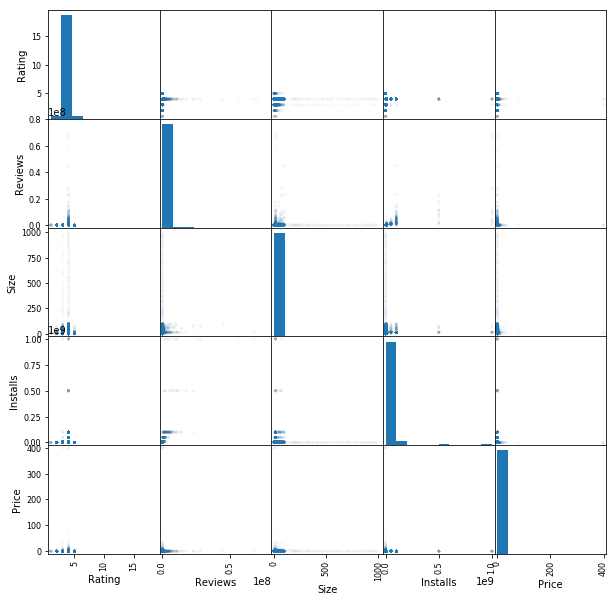

In [ ]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

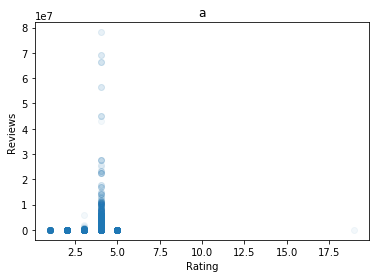

In [ ]:
plt.plot(data['Rating'], data['Reviews'], 'o', alpha = 0.05)
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.title('a')
pass

## Будем угадывать рейтинг, так что немного изменим содержание столбца.
Изменим столбец Rating на признак:
* 5 - рейтинг большей 4.5
* 4 - рейтинг от 3.5 до 4.5
* 3 - рейтинг от 2.5 до 3.5
* 2 - рейтинг от 1.5 до 2.5
* 1 - рейтинг меньше 1.5

In [ ]:
data.loc[data['Rating'] >= 4.5, 'Rating'] = 5
data.loc[(data['Rating'] >= 3.5) & (data['Rating'] < 4.5), 'Rating'] = 4
data.loc[(data['Rating'] >= 2.5) & (data['Rating'] < 3.5), 'Rating'] = 3
data.loc[(data['Rating'] >= 1.5) & (data['Rating'] < 2.5), 'Rating'] = 2
data.loc[data['Rating'] < 1.5, 'Rating'] = 1
data.head()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating
0,ART_AND_DESIGN,4,159,19,10000,0.0,Everyone
1,ART_AND_DESIGN,3,967,14,500000,0.0,Everyone
2,ART_AND_DESIGN,4,87510,8,5000000,0.0,Everyone
3,ART_AND_DESIGN,4,215644,25,50000000,0.0,Teen
4,ART_AND_DESIGN,4,967,2,100000,0.0,Everyone


## Проведём векторизацию.

In [ ]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

[] ['Category', 'Content Rating']


In [ ]:
data['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [ ]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)
data_nonbinary.head()

Index(['Category_1.9', 'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+',

,Category_1.9,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Нормализация

In [ ]:
data['Reviews'] = data['Reviews'].astype(int)
data['Size'] = data['Size'].astype(int)
data['Installs'] = data['Installs'].astype(int)

data_numerical = data[numerical_columns]
data_numerical.describe()

,Rating,Reviews,Size,Installs,Price
count,10841.000000,1.084100e+04,10841.000000,1.084100e+04,10841.000000
mean,3.809427,4.441121e+05,33.437045,1.546292e+07,1.027273
std,0.527848,2.927629e+06,91.210047,8.502557e+07,15.948971
min,1.000000,0.000000e+00,1.000000,0.000000e+00,0.000000
25%,4.000000,3.800000e+01,6.000000,1.000000e+03,0.000000
50%,4.000000,2.094000e+03,15.000000,1.000000e+05,0.000000
75%,4.000000,5.476800e+04,28.000000,5.000000e+06,0.000000
max,5.000000,7.815831e+07,1020.000000,1.000000e+09,400.000000


Нормируем все столбцы, кроме Rating.

In [ ]:
Rating = data_numerical['Rating']
data_numerical = data_numerical.drop('Rating', 1)
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical = data_numerical.assign(Rating=Rating.values)
data_numerical.describe()

,Reviews,Size,Installs,Price,Rating
count,1.084100e+04,1.084100e+04,1.084100e+04,1.084100e+04,10841.000000
mean,-2.514682e-16,-1.639563e-15,5.034510e-16,-9.792846e-16,3.809427
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.527848
min,-1.516969e-01,-3.556302e-01,-1.818620e-01,-6.441001e-02,1.000000
25%,-1.516839e-01,-3.008116e-01,-1.818503e-01,-6.441001e-02,4.000000
50%,-1.509816e-01,-2.021383e-01,-1.806859e-01,-6.441001e-02,4.000000
75%,-1.329896e-01,-5.961015e-02,-1.230562e-01,-6.441001e-02,4.000000
max,2.654510e+01,1.081638e+01,1.157931e+01,2.501558e+01,5.000000


Запишем все в таблицу

In [ ]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)
data.describe()

(10841, 45)


,Reviews,Size,Installs,Price,Rating,Category_1.9,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
count,1.084100e+04,1.084100e+04,1.084100e+04,1.084100e+04,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,...,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000
mean,-2.514682e-16,-1.639563e-15,5.034510e-16,-9.792846e-16,3.809427,0.000092,0.005996,0.007841,0.004889,0.021308,...,0.077760,0.023799,0.016142,0.007564,0.000277,0.803893,0.038188,0.046029,0.111429,0.000184
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.527848,0.009604,0.077203,0.088203,0.069752,0.144416,...,0.267806,0.152428,0.126029,0.086645,0.016634,0.397069,0.191660,0.209558,0.314677,0.013582
min,-1.516969e-01,-3.556302e-01,-1.818620e-01,-6.441001e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.516839e-01,-3.008116e-01,-1.818503e-01,-6.441001e-02,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.509816e-01,-2.021383e-01,-1.806859e-01,-6.441001e-02,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.329896e-01,-5.961015e-02,-1.230562e-01,-6.441001e-02,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2.654510e+01,1.081638e+01,1.157931e+01,2.501558e+01,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X = data.drop(('Rating'), axis = 1) # выбрасываем столбец 'Rating'
y = data['Rating']
feature_names = X.columns
feature_names

Index(['Reviews', 'Size', 'Installs', 'Price', 'Category_1.9',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER',
       'Content Rating_Adults only 18+', 'Content Rating_E

## Обучающая и тестовая выборка
Данные готовы, создадим выборки.

In [ ]:
print(X.shape)
print(y.shape)
N, d = X.shape

(10841, 44)
(10841,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

print(N_train, N_test)

7588 3253


In [ ]:
N_train+N_test

10841

## Метод ближайших соседей
Попробуем метод ближайших соседей.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print(err_train, err_test)

0.18779652082235107 0.2446972025822318


Возникло переобучение. Ошибка на тестовой выборке больше, чем на обучающей.

Попробуем подобрать параметры.

In [ ]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)


0.21033210332103325 45


In [ ]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.21020031628887717 0.20811558561328006


Получили немного более точный ответ при k = 45. Ошибки на тестовой и обучающей выборке примерно совпадают. Переобучения нет.

## Метод Random Forest

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0027675276752767526 0.21641561635413464


In [ ]:
np.sum(rf.feature_importances_)

1.0

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
 1. feature 'Reviews' (0.396484)
 2. feature ' Size' (0.260793)
 3. feature 'Installs' (0.135130)
 4. feature 'Price' (0.025491)
 5. feature 'Category_FAMILY' (0.012003)
 6. feature 'Content Rating_Everyone' (0.009586)
 7. feature 'Content Rating_Teen' (0.008181)
 8. feature 'Category_TOOLS' (0.007479)
 9. feature 'Category_GAME' (0.007331)
10. feature 'Category_MEDICAL' (0.007195)
11. feature 'Category_BUSINESS' (0.007131)
12. feature 'Category_LIFESTYLE' (0.006933)
13. feature 'Category_COMMUNICATION' (0.006133)
14. feature 'Category_NEWS_AND_MAGAZINES' (0.006082)
15. feature 'Category_FINANCE' (0.005749)
16. feature 'Category_PRODUCTIVITY' (0.005675)
17. feature 'Content Rating_Mature 17+' (0.005550)
18. feature 'Category_PHOTOGRAPHY' (0.005394)
19. feature 'Category_HEALTH_AND_FITNESS' (0.005244)
20. feature 'Category_TRAVEL_AND_LOCAL' (0.005221)
21. feature 'Category_SOCIAL' (0.004688)
22. feature 'Category_SPORTS' (0.004676)
23. feature 'Category_VIDEO_PLAYERS' (

In [ ]:
feature_names[[1,0,1]]

Index(['Size', 'Reviews', 'Size'], dtype='object')

(-1, 20)

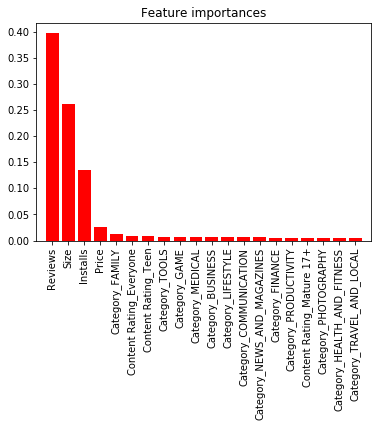

In [ ]:
d_first = 20
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), feature_names[indices[:d_first]], rotation = 90)
plt.xlim([-1, d_first])

Можно сделать вывод, что наибольший вклад в рейтинг оказывает число просмотров, размер приложения и число установок приложения.
Ошибка на тестовой выборке в данном методе все ещё высока.


Попробуем использовать сеть для решения задачи классификации.

## Однослойная сеть

Посмотрим на однослойную сеть, в скрытом слое которой находится 100 нейронов.

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs',
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

Ошибки на обучающей и тестовой выборке:

In [ ]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.20677385345282023 0.21303412234860128


Альтернативная запись:

In [ ]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.7932261465471797 0.7869658776513987


 Можно заметить, что ошибки близки. На тестовой выборке ошибка немного больше, чем на обучающей, следовательно переобучение небольшое есть.

## Двухслойная сеть
Посмотрим на двухслойную сеть, в каждом скрытом слое которой находится 100 нейронов.

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100, 100), solver = 'lbfgs',
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

Ошибки на обучающей и тестовой выборке:

In [ ]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.21020031628887717 0.21088226252689823


Ошибки снова близки, но переобучение стало меньше.

Попробуем ещё немного улучшить сеть с двумя скрытыми слоями через подбор гиперпараметров.

## Подбор гиперпараметра
Подберем оптимальное значение параметра регуляризации alpha

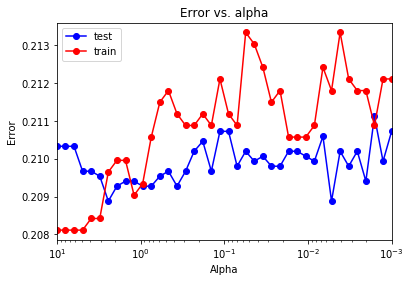

In [ ]:
alpha_arr = np.logspace(-3, 1, 40)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100, 100),
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.legend()
pass

Минимальное значение ошибки:

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.2088824459673168 0.20811558561328006


При оптимальных значениях alpha:

In [ ]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt[0])

4.923882631706737


In [ ]:
alpha_opt = alpha_opt[0]

Посмотрим на классификатор с оптимальным параметром. Для этого повторим обучение и посмотрим на ошибку.

In [ ]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100, 100),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.20967316816025303 0.20811558561328006


Ошибка на тестовой выборке меньше ошибки на обучающей, так что переобучения нет.

## Метрики качества

Матрица рассогласования:

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [  17   66  515 2576   79]
 [   0    0    0    0    0]]


Получается сеть всегда ставит рейтинг равный 4, и это верно примерно в 80% случаев.

Другие метрики:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        17
          2       0.00      0.00      0.00        66
          3       0.00      0.00      0.00       515
          4       0.79      1.00      0.88      2576
          5       0.00      0.00      0.00        79

avg / total       0.63      0.79      0.70      3253



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Используем random forests, extremely random forests, adaboost, gradient boosted trees. Построим графики зависимости ошибки (на тестовой и обучающейся выборках, а также oob-ошибку) от количества используемых деревьев.


## Метод Random Forest

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.0027675276752767526 0.21826006762988012


Обычно случайный лес не переобучается, но тут явно ошибка на обучающей выборке значительно меньше ошибки на тестовой выборке, следовательно имеет место переобучение. Попробуем подобрать более удачное число деревьев.

Построим зависимость числа ошибок на тестовой выборке и обучающей выборке в зависимости от числа деревьев. Так же построим OOB-ошибку.

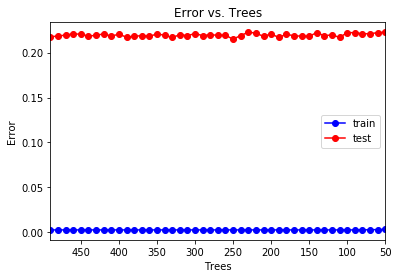

In [ ]:
trees_arr = np.arange(50, 500, 10)
test_err = []
train_err = []
oob_err = []
for trees in trees_arr:
    rf = ensemble.RandomForestClassifier(bootstrap=True, n_estimators = trees, oob_score=True)
    rf.fit(X_train, y_train)
    train_err.append(np.mean(y_train != rf.predict(X_train)))
    test_err.append(np.mean(y_test  != rf.predict(X_test)))
    oob_err.append(1 - rf.oob_score_)

plt.plot(trees_arr, train_err, 'b-o', label = 'train')
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(trees_arr), np.min(trees_arr)])
plt.title('Error vs. Trees')
plt.xlabel('Trees')
plt.ylabel('Error')
plt.legend()
pass

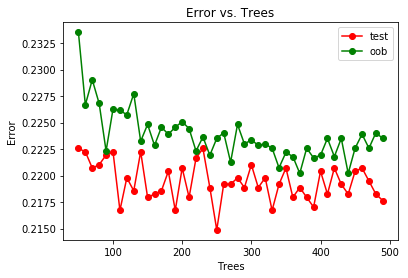

In [ ]:
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.plot(trees_arr, oob_err, 'g-o', label = 'oob')
plt.xlabel('Trees')
plt.ylabel('Error')
plt.title('Error vs. Trees')
plt.legend()
pass

Подбор оптимального числа деревьев не дал результата, переобучение все равно присутствует при любом числе деревьев.

Посмотрим на минимальную ошибку:

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0027675276752767526 0.21487857362434676


Число деревьев, при котором достигается минимальная ошибка:

In [ ]:
trees_opt = trees_arr[test_err == min_test_err]
print(trees_opt[0])

250


# Метод Extremely Random Forest

In [ ]:
from sklearn import ensemble
ert = ensemble.ExtraTreesClassifier(n_estimators = 100)
ert.fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print(err_train, err_test)

0.002635740643120717 0.25053796495542574


Снова видим переобучение.

Построим графики ошибок на тестовой выборке, обучающей выборке и OOB-ошибку в зависимости от числа деревьев.

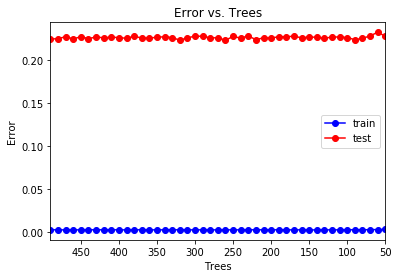

In [ ]:
trees_arr = np.arange(50, 500, 10)
test_err = []
train_err = []
oob_err = []
for trees in trees_arr:
    ert = ensemble.ExtraTreesClassifier(n_estimators = trees, oob_score=True, bootstrap=True)
    ert.fit(X_train, y_train)
    train_err.append(np.mean(y_train != ert.predict(X_train)))
    test_err.append(np.mean(y_test  != ert.predict(X_test)))
    oob_err.append(1 - ert.oob_score_)
plt.plot(trees_arr, train_err, 'b-o', label = 'train')
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(trees_arr), np.min(trees_arr)])
plt.title('Error vs. Trees')
plt.xlabel('Trees')
plt.ylabel('Error')
plt.legend()
pass

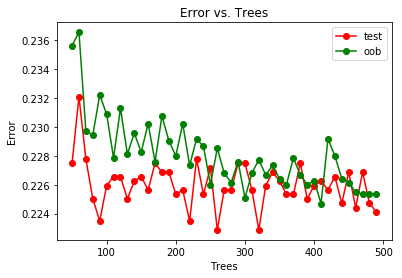

In [ ]:
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.plot(trees_arr, oob_err, 'g-o', label = 'oob')
plt.xlabel('Trees')
plt.ylabel('Error')
plt.title('Error vs. Trees')
plt.legend()
pass

В данном метода снова не удалось подбором числа деревьев улучшить результат. При любом числе деревьев от 50 до 500 наблюдается сильное переобучение.

Посмотрим каких результатов удалось достигнуть:

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.002635740643120717 0.22287119581924378


При этом оптимальное число деревьев:

In [ ]:
trees_opt = trees_arr[test_err == min_test_err]
print(trees_opt[0])

260


# Метод AdaBoost

In [ ]:
ab = ensemble.AdaBoostClassifier(n_estimators = 100)
ab.fit(X_train, y_train)

err_train = np.mean(y_train != ab.predict(X_train))
err_test  = np.mean(y_test  != ab.predict(X_test))

print(err_train, err_test)

0.39457037427517133 0.40823854903166307


 Ошибки имеют достаточно большое значение, но близки. Попробуем это исправить.

 Посмотрим на графики ошибок на обучающей и тестовой выборке в зависимости от числа деревьев.

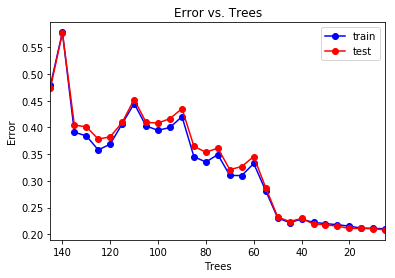

In [ ]:
trees_arr = np.arange(5, 150, 5)
test_err = []
train_err = []

for trees in trees_arr:
    ab = ensemble.AdaBoostClassifier(n_estimators = trees)
    ab.fit(X_train, y_train)
    train_err.append(np.mean(y_train != ab.predict(X_train)))
    test_err.append(np.mean(y_test  != ab.predict(X_test)))

plt.plot(trees_arr, train_err, 'b-o', label = 'train')
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(trees_arr), np.min(trees_arr)])
plt.title('Error vs. Trees')
plt.xlabel('Trees')
plt.ylabel('Error')
plt.legend()
pass

Похоже в этом случае удастся избежать переобучения и решить задачу с хорошей точность.

Посмотрим на минимальную ошибку:

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.21020031628887717 0.20811558561328006


Переобучения нет. Подтверждается свойство данного алгоритма менее поддаваться переобучению.

Оптимальное число деревьев:

In [ ]:
trees_opt = trees_arr[test_err == min_test_err]
print(trees_opt[0])

5


# Gradient boosted trees

In [ ]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test  = np.mean(y_test  != gbt.predict(X_test))

print(err_train, err_test)

0.1908276225619399 0.20965262834306794


Достаточно хороший результат, есть небольшое переобучение, попробуем это исправить.

Построим графики для ошибок на тестовой и обучающей выборках в зависимости от числа деревьев:

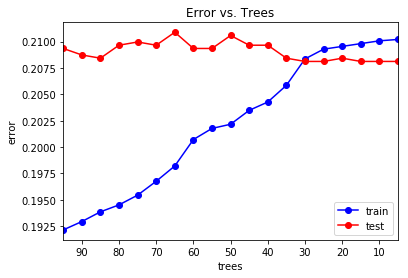

In [ ]:
trees_arr = np.arange(5, 100, 5)
test_err = []
train_err = []
for trees in trees_arr:
    gbt = ensemble.GradientBoostingClassifier(n_estimators = trees)
    gbt.fit(X_train, y_train)
    train_err.append(np.mean(y_train != gbt.predict(X_train)))
    test_err.append(np.mean(y_test  != gbt.predict(X_test)))
plt.plot(trees_arr, train_err, 'b-o', label = 'train')
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(trees_arr), np.min(trees_arr)])
plt.title('Error vs. Trees')
plt.xlabel('trees')
plt.ylabel('error')
plt.legend()
pass

С ростом числа деревьев ошибка только растёт. Можно заметить, что при количестве деревьев больше 30 будет переобучение. То есть с ростом сложности модели возникает переобучение.

Посмотрим на минимальную ошибку:

In [ ]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.19214549288350027 0.20811558561328006


Ошибка стала меньше, но присутствует небольшое переобучение.

Оптимальное число деревьев:

In [ ]:
trees_opt = trees_arr[test_err == min_test_err]
print(trees_opt[0])

5


Попробуем немного интерпретировать результат классификации.

In [ ]:
importances = gbt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(min(d, 10)):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
 1. feature 'Reviews' (0.367835)
 2. feature ' Size' (0.167138)
 3. feature 'Installs' (0.141045)
 4. feature 'Price' (0.046616)
 5. feature 'Category_FINANCE' (0.026497)
 6. feature 'Category_COMICS' (0.016270)
 7. feature 'Category_FAMILY' (0.016146)
 8. feature 'Category_GAME' (0.015830)
 9. feature 'Category_LIFESTYLE' (0.015157)
10. feature 'Category_HEALTH_AND_FITNESS' (0.014781)


(-1, 4)

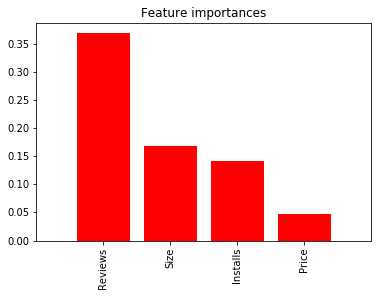

In [ ]:
d_first = min(d, 4)
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), feature_names[indices[:d_first]], rotation = 90)
plt.xlim([-1, d_first])

Можно сделать вывод, что рейтинг приложения по нашему набору данных определяется в основном по числу просмотров.